<h1>Analysis of Azog C1 chip: Bloch oscillations</h1>
Online analysis script used to analyse the data collected during the cooldown of the chip.

In [1]:
sample_name = 'azog_c1'                    # name of the chip in the fridge

<h3>Basic imports</h3>

In [2]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import pandas as pd

import qcodes as qc
from qcodes import initialise_database, load_by_id
from qcodes.dataset.plotting import plot_by_id

import scipy.optimize

In [3]:
# plot options
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=24)
#plt.rcParams.update({'font.size': 16})

<h2>Data analysis and plotting</h2>

In [4]:
db_name = 'zenodo_export_MWon.db'   # name of the database
db_path  = os.path.join(db_name)

qc.initialise_or_create_database_at(db_path)

<h4>IV with and without microwaves</h4>

In [12]:
# mw off
RUN_ID = 1 #57
dataset = qc.load_by_id(run_id=RUN_ID)
mwoff_df_dict = dataset.to_pandas_dataframe_dict()

# mw 3.20GHz
RUN_ID = 2
dataset = qc.load_by_id(run_id=RUN_ID)
mw315_df_dict = dataset.to_pandas_dataframe_dict()

# mw 4.04GHz
RUN_ID = 3 # 5 
dataset = qc.load_by_id(run_id=RUN_ID)
mw404_df_dict = dataset.to_pandas_dataframe_dict()

# mw 4.04GHz bis
RUN_ID = 4 # 5 
dataset = qc.load_by_id(run_id=RUN_ID)
mw404_df_dict_bis = dataset.to_pandas_dataframe_dict()

# mw 5.45GHz
RUN_ID = 5 # 6 42
dataset = qc.load_by_id(run_id=RUN_ID)
mw544_df_dict = dataset.to_pandas_dataframe_dict()

# mw 6.11Hz
RUN_ID = 6 # 7
dataset = qc.load_by_id(run_id=RUN_ID)
mw611_df_dict = dataset.to_pandas_dataframe_dict()

# mw 6.46GHz
RUN_ID = 7 # 8 49
dataset = qc.load_by_id(run_id=RUN_ID)
mw646_df_dict = dataset.to_pandas_dataframe_dict()

# mw 7.49GHz
RUN_ID = 8
dataset = qc.load_by_id(run_id=RUN_ID)
mw749_df_dict = dataset.to_pandas_dataframe_dict()

ivmw_runs = [ mwoff_df_dict, mw315_df_dict, mw404_df_dict, mw544_df_dict, mw611_df_dict, mw646_df_dict ] #, mw749_df_dict]

<h5>Data shaping</h5>

In [13]:
V_lh = []
I_lh = []
V_hl = []
I_hl = []
ind = 0

for run in ivmw_runs:
    #run = mw646_df_dict
    
    # up ramps
    run_up_0 = run['adwin_up_ramp']
    run_up_1 = run_up_0.reset_index()
    v_up = run_up_1['adwin_input_2_voltage_up'].to_numpy()
    i_up = run_up_1['adwin_up_ramp'].to_numpy()
    
    # down ramps
    run_down_0 = run['adwin_down_ramp']
    run_down_1 = run_down_0.reset_index()
    v_down = run_down_1['adwin_input_2_voltage_down'].to_numpy()
    i_down = run_down_1['adwin_down_ramp'].to_numpy()
    
    # divide into low-to-high and high-to-low
    N = len(v_up)
    # added manually
    #zero_index_up = np.argmin(np.abs(i_up))
    #zero_index_down = np.argmin(np.abs(i_down))
    zero_index_up = [ 8000, 2726, 5070, 5070, 8050, 5070 ]
    zero_index_down = [ 8035, 2726, 5100, 5100, 8030, 5120 ]

    #v_lh = np.concatenate(( np.flip(v_down[zero_index_down:]), v_up[zero_index_up:] ))
    i_lh = np.concatenate(( np.flip(i_down[zero_index_down[ind]:]), i_up[zero_index_up[ind]:] ))
    v_lh = np.linspace(np.min(v_down), np.max(v_up), len(i_lh))
    V_lh.append(v_lh)
    I_lh.append(i_lh)
    
    #v_hl = np.concatenate(( v_up[:zero_index_up], np.flip(v_down[:zero_index_down]) ))
    i_hl = np.concatenate(( i_up[:zero_index_up[ind]], np.flip(i_down[:zero_index_down[ind]]) ))
    v_hl = np.linspace(np.min(v_up), np.max(v_down), len(i_hl))
    V_hl.append(v_hl)
    I_hl.append(i_hl)    
    
    ind+=1

<h5>Plotting</h5>

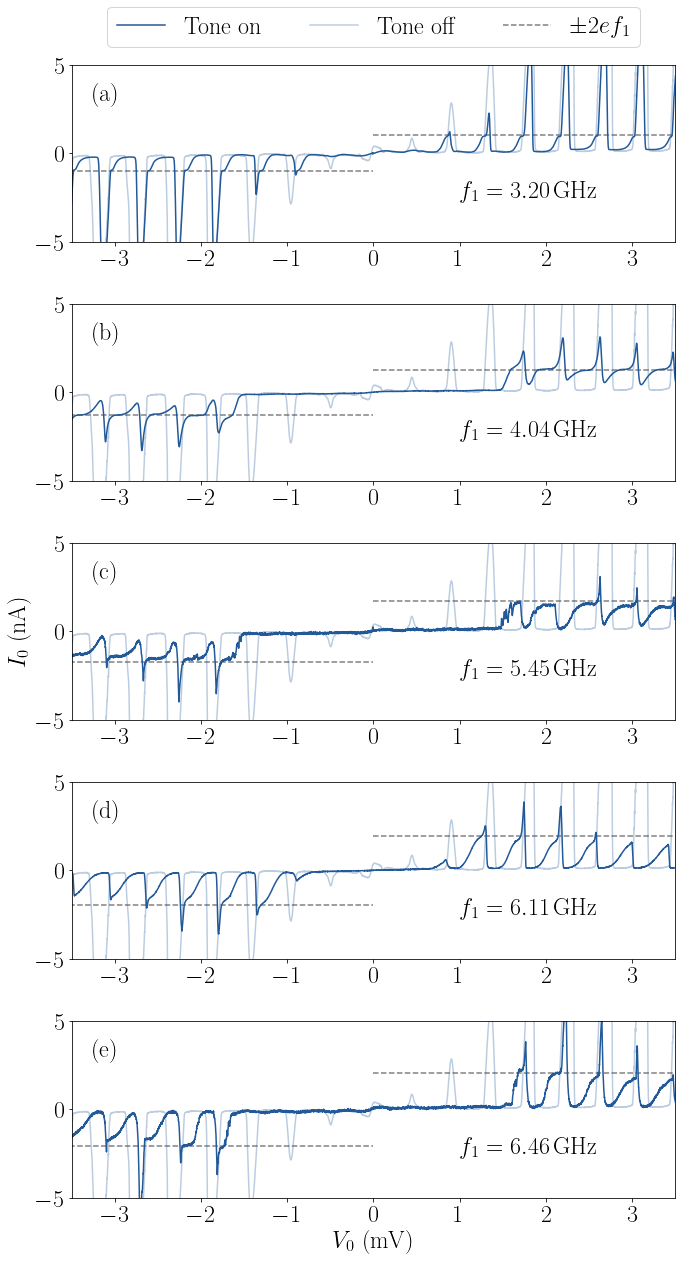

In [14]:
e = 1.6e-19
frequencies = [ 0, 3.20e9, 4.04e9, 5.45e9, 6.11e9, 6.46e9 ] # 7.48e9
steps_number = len(frequencies)
color_iv = '#225999'

voltage_scale = 1e3
current_scale = 1e9
xrange_mv = 3.5

#plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(steps_number-1, 1, figsize=(10,18))

# plot all
for index in range(1, steps_number):
    
    ax[index-1].plot(voltage_scale*V_lh[index], current_scale*I_lh[index], c=color_iv, label='Tone on')
    ax[index-1].plot(voltage_scale*V_lh[0], current_scale*I_lh[0], alpha=0.3, c=color_iv, label='Tone off')
    ax[index-1].set_xlim([-xrange_mv, xrange_mv])    

    ax[index-1].text( 1, -2.5, '$f_1 =%0.2f \,\mathrm{GHz}$' % (frequencies[index]/1e9) )
    ax[index-1].hlines(2*e*frequencies[index]*current_scale, 0, 5, linestyles='dashed', colors='black', alpha=0.5, label='$\pm 2ef_1$')
    ax[index-1].hlines(-2*e*frequencies[index]*current_scale, -5, 0, linestyles='dashed', colors='black', alpha=0.5)
    ax[index-1].set_ylim([-5,5])
    
    
    ax[-1].plot()

ax[-1].set_xlabel('$V_0$ (mV)')
ax[2].set_ylabel('$I_0$ (nA)')

ax[0].text( -3.25, 3, '(a)' )
ax[1].text( -3.25, 3, '(b)' )
ax[2].text( -3.25, 3, '(c)' )
ax[3].text( -3.25, 3, '(d)' )
ax[4].text( -3.25, 3, '(e)' )

ax[0].legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.4))
fig.tight_layout()

#plt.savefig('iv_f.pdf', bbox_inches='tight')

<h4>IV with and without microwaves $4\,\mathrm{GHz}$</h4>

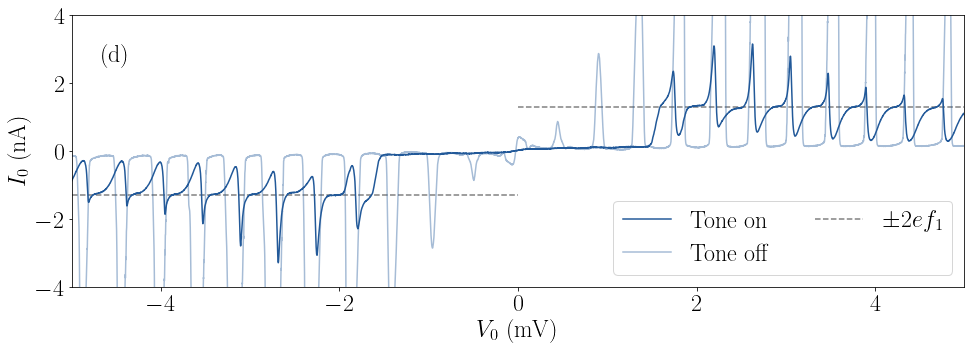

In [15]:
fig, ax = plt.subplots(1,1, figsize=(16,5))

ax.plot(voltage_scale*V_lh[2], current_scale*I_lh[2], c='#225999', label='Tone on')
ax.plot(voltage_scale*V_lh[0], current_scale*I_lh[0], c='#225999', alpha=0.4, label='Tone off')
ax.set_xlim([-5, 5])
ax.set_ylim([-4, 4])
ax.set_ylabel('$I_0$ (nA)')
ax.set_xlabel('$V_0$ (mV)')

ax.hlines(2*e*frequencies[2]*current_scale, 0, 5, linestyles='dashed', colors='black', alpha=0.5, label='$\pm 2ef_1$')
ax.hlines(-2*e*frequencies[2]*current_scale, -5, 0, linestyles='dashed', colors='black', alpha=0.5)

ax.text(0.05, 0.85, '(d)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.legend(loc='lower right', ncol=2)

#plt.savefig('iv_404.pdf', bbox_inches='tight')

<h4>S21 as a function of MW tone power and frequency</h4>

In [16]:
# loading vna data
RUN_ID = 9
dataset = qc.load_by_id(run_id=RUN_ID)
vna2d_f = dataset.to_pandas_dataframe_dict()

RUN_ID = 10
dataset = qc.load_by_id(run_id=RUN_ID)
vna2d_p = dataset.to_pandas_dataframe_dict()

RUN_ID = 11
dataset = qc.load_by_id(run_id=RUN_ID)
vna2d_pz = dataset.to_pandas_dataframe_dict()

In [17]:
# VNA spectra frequency
vnadc_vna_0 = vna2d_f['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

fa = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwf = vnadc_vna_1['mw_source_frequency'].to_numpy()
maga = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fa).size)
fa = np.reshape(fa, m_size)
mwf = np.reshape(mwf, m_size)
maga = np.reshape(maga, m_size)

# VNA spectra power
vnadc_vna_0 = vna2d_p['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

fb = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwp = vnadc_vna_1['mw_source_power'].to_numpy()
magb = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fa).size)
fb = np.reshape(fb, m_size)
mwp = np.reshape(mwp, m_size)
magb = np.reshape(magb, m_size)

# VNA spectra power zoomed
vnadc_vna_0 = vna2d_pz['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

fc = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwpz = vnadc_vna_1['mw_source_power'].to_numpy()
magc = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fc).size)
fc = np.reshape(fc, m_size)
mwpz = np.reshape(mwpz, m_size)
magc = np.reshape(magc, m_size)

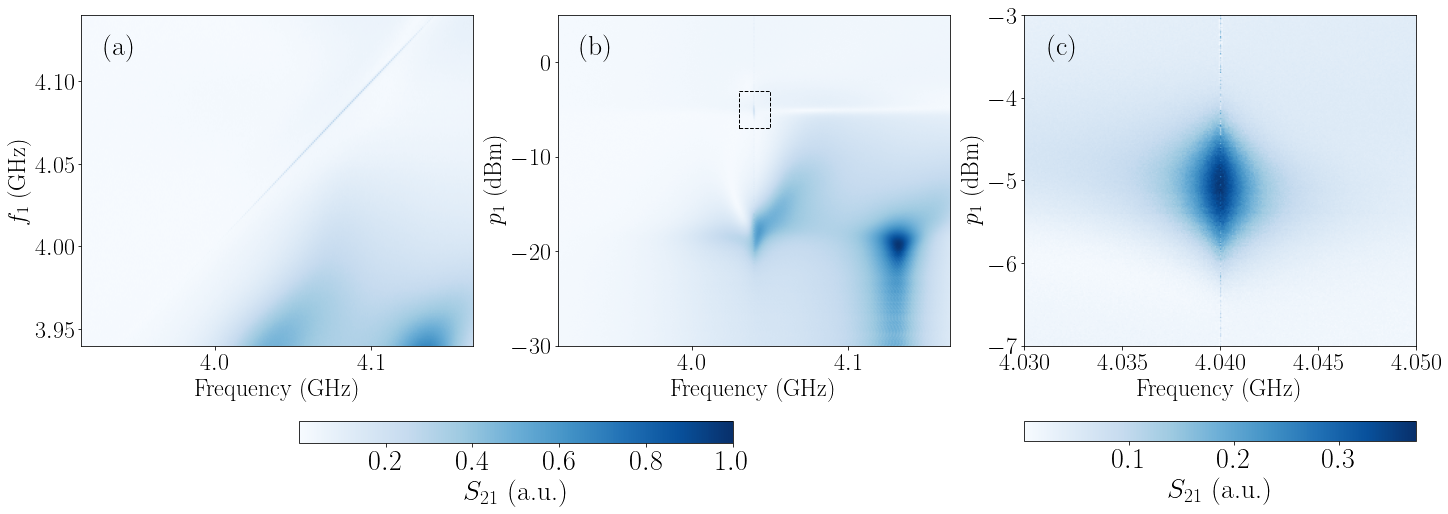

In [18]:
fig, ax = plt.subplots(1,3, figsize=(20,7), constrained_layout=True)
plt.rcParams.update({'font.size': 28})
frequency_scale = 1e-9
vmin = np.min(maga)
vmax = np.max(magb)
vmin_zoom = np.min(magc)
vmax_zoom = np.max(magc)


cmap = 'Blues'

p0 = ax[0].imshow(maga[::-1] / vmax, aspect='auto', cmap=cmap, 
             extent=[ np.min(fa)*frequency_scale, np.max(fa)*frequency_scale, np.min(mwf)*frequency_scale, np.max(mwf)*frequency_scale ], vmin=vmin/vmax, vmax=1)
ax[0].set_xlabel('Frequency (GHz)')
ax[0].set_ylabel('$f_1$ (GHz)')
ax[0].text(0.1, 0.9, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes)


p1 = ax[1].imshow(magb[::-1] / vmax, aspect='auto', cmap=cmap,
             extent=[ np.min(fb)*frequency_scale, np.max(fb)*frequency_scale, np.min(mwp), np.max(mwp) ], vmin=vmin/vmax, vmax=1)
ax[1].set_xlabel('Frequency (GHz)')
ax[1].set_ylabel('$p_1$ (dBm)')
ax[1].text(0.1, 0.9, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax[1].transAxes)


rect = plt.Rectangle((4.03, -7), 0.02, 4,
                     fill=False, edgecolor='black', linestyle='dashed')
ax[1].add_patch(rect)

p2 = ax[2].imshow(magc[::-1, 1100:1400] / vmax, aspect='auto', cmap=cmap,
             extent=[ np.min(fc)*frequency_scale, np.max(fc)*frequency_scale, np.min(mwpz), np.max(mwpz) ], vmin=vmin_zoom/vmax, vmax=vmax_zoom/vmax)
ax[2].set_xlabel('Frequency (GHz)')
ax[2].set_ylabel('$p_1$ (dBm)')
#ax[2].set_xlim([-6.99,-3])
ax[2].text(0.1, 0.9, '(c)', horizontalalignment='center', verticalalignment='center', transform=ax[2].transAxes)


cp01 = fig.colorbar(p0, ax=ax[:2], label='$S_{21}$ (a.u.)', shrink=0.5, location='bottom')
#fig.colorbar(p1, ax=ax[1], label='$S_{21}$ (a.u.)', shrink=0.8, location='bottom')
cbp2 = fig.colorbar(p2, ax=ax[2], label='$S_{21}$ (a.u.)', shrink=1, location='bottom')
#cbp2.formatter.set_powerlimits((0, 0))

#plt.tight_layout()
#plt.savefig('pfsweep.pdf', bbox_inches='tight')

<h4>S21 as a function of DC voltage with microwaves</h4>
Takes a lot of time to load !

In [5]:
# loading vna data
RUN_ID = 12
dataset = qc.load_by_id(run_id=RUN_ID)
vnadc_vna_dict = dataset.to_pandas_dataframe_dict()

RUN_ID = 3 # 36, 58
dataset = qc.load_by_id(run_id=RUN_ID)
vnadc_dc_dict = dataset.to_pandas_dataframe_dict()


In [6]:
# IV curve
vnadc_dc_up_0 = vnadc_dc_dict['adwin_up_ramp']
vnadc_dc_up_1 = vnadc_dc_up_0.reset_index()
v_up = vnadc_dc_up_1['adwin_input_2_voltage_up'].to_numpy()
i_up = vnadc_dc_up_1['adwin_up_ramp'].to_numpy()

# down ramp
vnadc_dc_down_0 = vnadc_dc_dict['adwin_down_ramp']
vnadc_dc_down_1 = vnadc_dc_down_0.reset_index()
v_down = vnadc_dc_down_1['adwin_input_2_voltage_down'].to_numpy()
i_down = vnadc_dc_down_1['adwin_down_ramp'].to_numpy()

# divide into low-to-high and high-to-low
N = len(v_up)
zero_index_up = np.argmin(np.abs(i_up))
zero_index_down = np.argmin(np.abs(i_down))

v_dc_lh = np.concatenate(( np.flip(v_down[zero_index_down:]), v_up[zero_index_up:] ))
i_dc_lh = np.concatenate(( np.flip(i_down[zero_index_down:]), i_up[zero_index_up:] ))
v_dc_hl = np.concatenate(( v_up[:zero_index_up], np.flip(v_down[:zero_index_down]) ))
i_dc_hl = np.concatenate(( i_up[:zero_index_up], np.flip(i_down[:zero_index_down]) ))

# VNA spectra
vnadc_vna_0 = vnadc_vna_dict['ZNB20_S21_magnitude']
vnadc_vna_1 = vnadc_vna_0.reset_index()

frq = vnadc_vna_1['ZNB20_S21_S21_frequency'].to_numpy()
v_bias = vnadc_vna_1['adwin_output1'].to_numpy()
mag = vnadc_vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(frq).size)
frq = np.reshape(frq, m_size)
v_bias = np.reshape(v_bias, m_size)
mag = np.reshape(mag, m_size)

(0.0, 7.0)

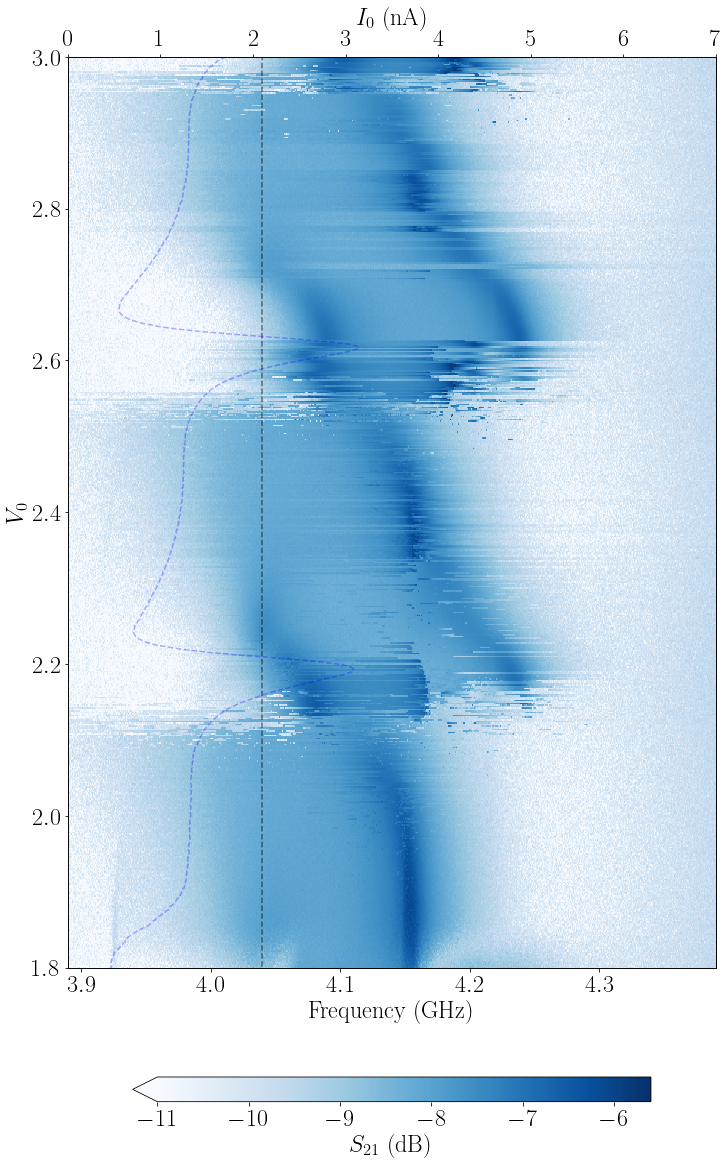

In [7]:
fig, ax1 = plt.subplots(figsize=(10,16), constrained_layout=True)
voltage_scaling = 1e3
voltage_offset = 0.05
frequency_scaling = 1e-9
current_scaling = 1e9

ctf = ax1.pcolormesh(frequency_scaling*frq, v_bias, np.log(mag), shading='auto', cmap='Blues', vmin=-11)
fig.colorbar(ctf, label='$S_{21}$ (dB)', extend="min", location='bottom', shrink=0.8)
ax1.vlines(4.04, 0, 5, linestyles='dashed', colors='black', alpha=0.5)
ax1.set_ylabel('$V_0$')
ax1.set_xlabel('Frequency (GHz)')
ax1.set_ylim([1.8,3])

ax2 =ax1.twiny()
ax2.plot(current_scaling*np.abs(i_up), voltage_scaling*v_up - voltage_offset, 'b--', alpha=0.3)
ax2.set_xlabel('$I_0$ (nA)');
ax2.set_xlim([0,7])

#plt.tight_layout()
#plt.savefig('s21_dc_mwon.png', bbox_inches='tight')

<h4>Power dependence</h4>

In [10]:
# loading
RUN_ID = 33
dataset = qc.load_by_id(run_id=RUN_ID)
dIdp = dataset.to_pandas_dataframe_dict()

In [8]:
# loading
RUN_ID = 14 # 4
dataset = qc.load_by_id(run_id=RUN_ID)
iv40_stat = dataset.to_pandas_dataframe_dict()

<h5>Data shaping</h5>

In [11]:
# up ramp
iv40_stat_0 = iv40_stat['adwin_up_ramp']
iv40_stat_1 = iv40_stat_0.reset_index()

pwr_up = iv40_stat_1['mw_source_power'].to_numpy()
v_up = iv40_stat_1['adwin_input_2_voltage_up'].to_numpy()
i_up = iv40_stat_1['adwin_up_ramp'].to_numpy()

# down ramp
iv40_stat_0 = iv40_stat['adwin_down_ramp']
iv40_stat_1 = iv40_stat_0.reset_index()

pwr_down = iv40_stat_1['mw_source_power'].to_numpy()
v_down = iv40_stat_1['adwin_input_2_voltage_down'].to_numpy()
i_down = iv40_stat_1['adwin_down_ramp'].to_numpy()

# reshape to form a 2D array
N = np.unique(pwr_up).shape[0] 
size = (N, -1)

pwr40_up = np.reshape(pwr_up, size)
v40_up = np.reshape(v_up, size)
i40_up = np.reshape(i_up, size)
pwr40_down = np.reshape(pwr_down, size)
v40_down = np.reshape(v_down, size)
i40_down = np.reshape(i_down, size)

dIdp_df_0 = dIdp['lockin_R']
dIdp_df_1 = dIdp_df_0.reset_index()
dp = dIdp_df_1['mw_source_power'].to_numpy()
dI = dIdp_df_1['lockin_R'].to_numpy()

Text(1, -3.1, '(a)')

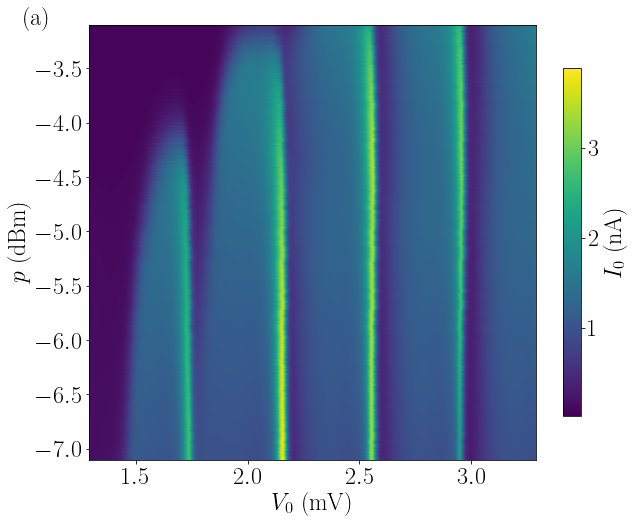

In [12]:
plt.figure(figsize=(10,8))
current_scale = 1e9
voltage_scale = 1e3

plt.imshow(current_scale*i40_up[::-1], aspect='auto', extent = [ voltage_scale*np.min(v40_up[0]), voltage_scale*np.max(v40_up), np.min(pwr40_up), np.max(pwr40_up) ])
#plt.text(1.95,-3.7, '$1^\mathrm{st}$', c='white')
#plt.text(2.35,-3.7, '$2^\mathrm{nd}$', c='white')
#plt.text(2.75,-3.7, '$3^\mathrm{rd}$', c='white')
#plt.text(3.10,-3.7, '$4^\mathrm{th}$', c='white')

#plt.text(0.95, -3.3, '(b)')
plt.xlabel('$V_0$ (mV)')
plt.ylabel('$p$ (dBm)')
plt.colorbar(label='$I_0$ (nA)', shrink=0.8)
plt.text(1, -3.1, '(a)')

#plt.savefig("steps_pd_2d.pdf", bbox_inches='tight')

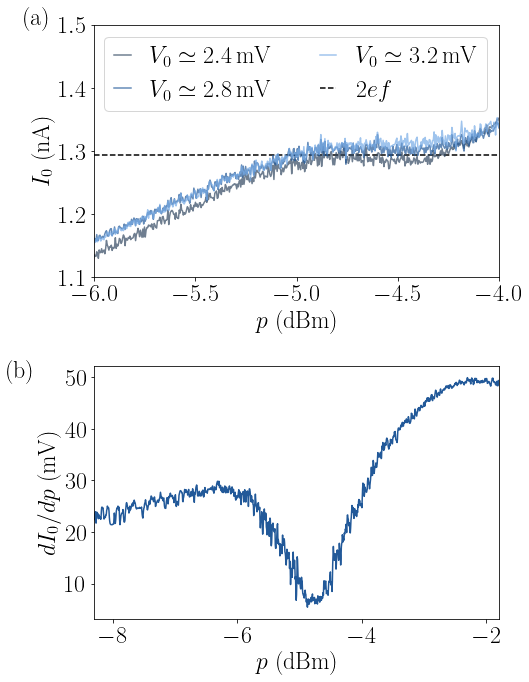

In [15]:
# power dependence: RUN ID 22
e = 1.6e-19
f = 4.04e9

avg2 = np.mean(i40_up[:, 1350:1470], axis=1)
avg3 = np.mean(i40_up[:, 1840:1930], axis=1)
avg4 = np.mean(i40_up[:, 2375:2420], axis=1)

line_2 = np.poly1d( np.polyfit(pwr40_up[0:50,0], avg2[0:50], 1) )
line_3 = np.poly1d( np.polyfit(pwr40_up[0:50,0], avg3[0:50], 1) )
line_4 = np.poly1d( np.polyfit(pwr40_up[0:50,0], avg4[0:50], 1) )


fig, ax = plt.subplots(2, 1, figsize=(8,10))
current_scale = 1e9

ax[0].plot(pwr40_up[:, 0], current_scale*avg2, c='#324861', alpha=0.7, label='$V_0\simeq2.4\,\mathrm{mV}$')
#ax[0].plot(pwr40_up[:, 0], current_scale*line_2(pwr40_up[:, 0]))
ax[0].plot(pwr40_up[:, 0], current_scale*avg3, c='#225999', alpha=0.7, label='$V_0\simeq2.8\,\mathrm{mV}$')
#ax[0].plot(pwr40_up[:, 0], current_scale*line_3(pwr40_up[:, 0]))
ax[0].plot(pwr40_up[:, 0], current_scale*avg4, c='#77ABE6', alpha=0.7, label='$V_0\simeq3.2\,\mathrm{mV}$')
#ax[0].plot(pwr40_up[:, 0], current_scale*line_4(pwr40_up[:, 0]))

ax[0].hlines([current_scale*2*e*f], -6,-4, 'black', linestyle='dashed', label='$2ef$')
ax[0].set_xlim([-6,-4])
ax[0].set_ylim([1.1,1.5])
ax[0].legend(handlelength=0.7, ncol=2)
ax[0].set_xlabel("$p$ (dBm)")
ax[0].set_ylabel("$I_0$ (nA)")

# lock-in dI/dp: RUN 13
power_offset = 0.4 # see spectrum analyser run, the offsett is related to calibration losses
ax[1].plot(dp-power_offset, voltage_scale*dI, c='#225999')
ax[1].set_xlim([-7.9-power_offset,-1.4 - power_offset])
ax[1].set_xlabel('$p$ (dBm)')
ax[1].set_ylabel('$dI_0/dp$ (mV)')


ax[0].text(-6.35, 1.5, '(a)')     
ax[1].text(-9.7, 50, '(b)')        
fig.tight_layout()

#plt.savefig("steps_pd.pdf", bbox_inches='tight')

<h4>$S_{21}$ power dependence for all modes</h4>

In [16]:
# loading vna data
RUN_ID = 15 # 69
dataset = qc.load_by_id(run_id=RUN_ID)
s21_3 = dataset.to_pandas_dataframe_dict()

# loading vna data
RUN_ID = 16
dataset = qc.load_by_id(run_id=RUN_ID)
s21_4 = dataset.to_pandas_dataframe_dict()

# loading vna data
RUN_ID = 17
dataset = qc.load_by_id(run_id=RUN_ID)
s21_5 = dataset.to_pandas_dataframe_dict()

# loading vna data
RUN_ID = 18
dataset = qc.load_by_id(run_id=RUN_ID)
s21_6a = dataset.to_pandas_dataframe_dict()

# loading vna data
RUN_ID = 19
dataset = qc.load_by_id(run_id=RUN_ID)
s21_6b = dataset.to_pandas_dataframe_dict()

# loading vna data
RUN_ID = 20
dataset = qc.load_by_id(run_id=RUN_ID)
s21_7 = dataset.to_pandas_dataframe_dict()

<h5>Data shaping</h5>

In [17]:
# VNA 3.20GHz
vna_0 = s21_3['ZNB20_S21_magnitude']
vna_1 = vna_0.reset_index()

fb_3 = vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwp_3 = vna_1['mw_source_power'].to_numpy()
mag_3 = vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fb_3).size)
fb_3 = np.reshape(fb_3, m_size)
mwp_3 = np.reshape(mwp_3, m_size)
mag_3 = np.reshape(mag_3, m_size)

# VNA 4.04GHz
vna_0 = s21_4['ZNB20_S21_magnitude']
vna_1 = vna_0.reset_index()

fb_4 = vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwp_4 = vna_1['mw_source_power'].to_numpy()
mag_4 = vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fb_4).size)
fb_4 = np.reshape(fb_4, m_size)
mwp_4 = np.reshape(mwp_4, m_size)
mag_4 = np.reshape(mag_4, m_size)

# VNA 5.45GHz
vna_0 = s21_5['ZNB20_S21_magnitude']
vna_1 = vna_0.reset_index()

fb_5 = vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwp_5 = vna_1['mw_source_power'].to_numpy()
mag_5 = vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fb_5).size)
fb_5 = np.reshape(fb_5, m_size)
mwp_5 = np.reshape(mwp_5, m_size)
mag_5 = np.reshape(mag_5, m_size)

# VNA 6.11GHz
vna_0 = s21_6a['ZNB20_S21_magnitude']
vna_1 = vna_0.reset_index()

fb_6a = vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwp_6a = vna_1['mw_source_power'].to_numpy()
mag_6a = vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fb_6a).size)
fb_6a = np.reshape(fb_6a, m_size)
mwp_6a = np.reshape(mwp_6a, m_size)
mag_6a = np.reshape(mag_6a, m_size)

# VNA 6.45GHz
vna_0 = s21_6b['ZNB20_S21_magnitude']
vna_1 = vna_0.reset_index()

fb_6b = vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwp_6b = vna_1['mw_source_power'].to_numpy()
mag_6b = vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fb_6b).size)
fb_6b = np.reshape(fb_6b, m_size)
mwp_6b = np.reshape(mwp_6b, m_size)
mag_6b = np.reshape(mag_6b, m_size)

# VNA 7.48GHz
vna_0 = s21_7['ZNB20_S21_magnitude']
vna_1 = vna_0.reset_index()

fb_7 = vna_1['ZNB20_S21_S21_frequency'].to_numpy()
mwp_7 = vna_1['mw_source_power'].to_numpy()
mag_7 = vna_1['ZNB20_S21_magnitude'].to_numpy()

m_size = (-1, np.unique(fb_7).size)
fb_7 = np.reshape(fb_7, m_size)
mwp_7 = np.reshape(mwp_7, m_size)
mag_7 = np.reshape(mag_7, m_size)

mags = [ mag_3, mag_4, mag_5, mag_6a, mag_6b, mag_7 ]
pwrs = [ mwp_3, mwp_4, mwp_5, mwp_6a, mwp_6b, mwp_7 ]
frqs = [ fb_3, fb_4, fb_5, fb_6a, fb_6b, fb_7 ]
letters = [ '(a)', '(b)', '(c)', '(d)', '(e)', '(f)' ]

<h5>Plotting</h5>

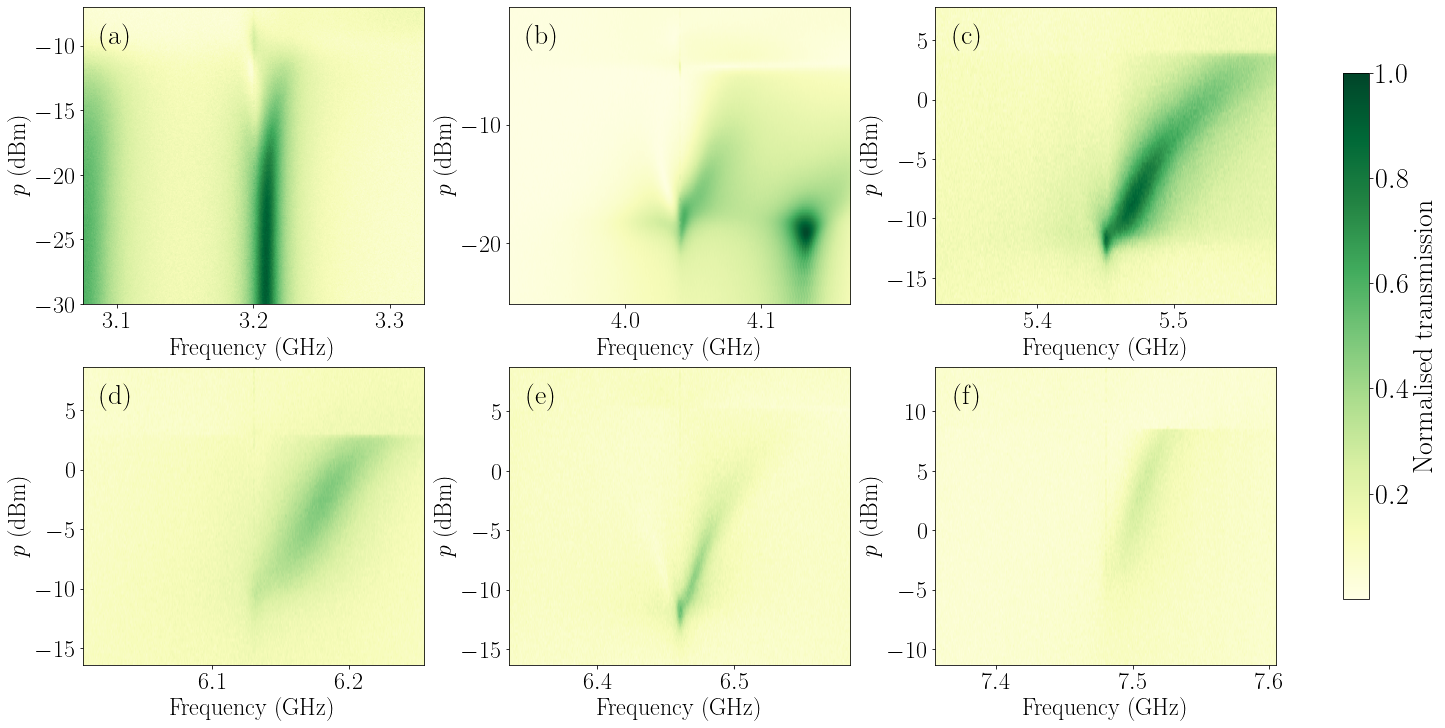

In [18]:
fig, ax = plt.subplots(2,3, figsize=(20,10), constrained_layout=True)
plt.rcParams.update({'font.size': 28})
frequency_scale = 1e-9
cmap = 'YlGn'

for i in range( len(mags) ):
    mag = mags[i]
    pwr = pwrs[i]
    frq = frqs[i]
    
    indy = i%3
    indx = int(( 3%(i+1) )/2)
    #print(indx, indy)
    
    vmin = np.min(mag)
    vmax = np.max(mag)
    fmin = np.min(frq)
    fmax = np.max(frq)
    pmin = np.min(pwr)
    pmax = np.max(pwr)

    p0 = ax[indx,indy].imshow(mag[::-1]/vmax, aspect='auto', cmap=cmap, 
                 extent=[ fmin*frequency_scale, fmax*frequency_scale, pmin, pmax ], vmin=vmin/vmax, vmax=1)
    
    ax[indx,indy].set_xlabel('Frequency (GHz)')
    ax[indx,indy].set_ylabel('$p$ (dBm)')
    ax[indx,indy].text(0.1, 0.9, letters[i], horizontalalignment='center', verticalalignment='center', transform=ax[indx,indy].transAxes)

fig.colorbar(p0, ax=ax.ravel().tolist(), label='Normalised transmission', shrink=0.8)
    
#plt.tight_layout()
# plt.savefig('psweeps.pdf', bbox_inches='tight')

<h4>Flux dependence of all the steps</h4>

In [19]:
# loading 3GHz
RUN_ID = 21
dataset = qc.load_by_id(run_id=RUN_ID)
ivsf3ghz_dict = dataset.to_pandas_dataframe_dict()

# loading 4GHz
RUN_ID = 22
dataset = qc.load_by_id(run_id=RUN_ID)
ivsf4ghz_dict = dataset.to_pandas_dataframe_dict()

# loading 5GHz
RUN_ID = 23
dataset = qc.load_by_id(run_id=RUN_ID)
ivsf5ghz_dict = dataset.to_pandas_dataframe_dict()

# loading 6GHz
RUN_ID = 24
dataset = qc.load_by_id(run_id=RUN_ID)
ivsf6ghz_dict = dataset.to_pandas_dataframe_dict()

dicts_flux_steps = [ ivsf3ghz_dict, ivsf4ghz_dict, ivsf5ghz_dict, ivsf6ghz_dict ]

<h5>Data shaping</h5>

In [20]:
flux_steps = []   
flux_voltage = []
    
for ivstemp_dict in dicts_flux_steps:
    # up ramp
    ivsf_up_0 = ivstemp_dict['adwin_up_ramp']
    ivsf_up_1 = ivsf_up_0.reset_index()

    Ib_up = ivsf_up_1['current_source_current'].to_numpy()
    v_up = ivsf_up_1['adwin_input_2_voltage_up'].to_numpy()
    i_up = ivsf_up_1['adwin_up_ramp'].to_numpy()

    # down ramp
    ivsf_down_0 = ivstemp_dict['adwin_down_ramp']
    ivsf_down_1 = ivsf_down_0.reset_index()

    Ib_down = ivsf_down_1['current_source_current'].to_numpy()
    v_down = ivsf_down_1['adwin_input_2_voltage_down'].to_numpy()
    i_down = ivsf_down_1['adwin_down_ramp'].to_numpy()

    # reshape to form a 2D array
    N = 6666 # hardcoded for now
    size = (-1, N)

    Ib_up = np.reshape(Ib_up, size)
    v_up = np.reshape(v_up, size)
    i_up = np.reshape(i_up, size)
    Ib_down = np.reshape(Ib_down, size)
    v_down = np.reshape(v_down, size)
    i_down = np.reshape(i_down, size)

    # divide into low-to-high and high-to-low
    M = len(i_up)
    zero_index_up = np.argmin(np.abs(i_up[51]))
    zero_index_down = np.argmin(np.abs(i_down[51]))

    v_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
    v_hl = np.zeros((M, zero_index_down + zero_index_up))
    i_lh = np.zeros((M, 2*N - zero_index_down - zero_index_up))
    i_hl = np.zeros((M, zero_index_down + zero_index_up))

    for i in range(M):
        v_lh[i] = np.concatenate(( np.flip(v_down[i][zero_index_down:]), v_up[i][zero_index_up:] ))
        v_hl[i] = np.concatenate(( v_up[i][:zero_index_up], np.flip(v_down[i][:zero_index_down]) ))
        i_lh[i] = np.concatenate(( np.flip(i_down[i][zero_index_down:]), i_up[i][zero_index_up:] ))
        i_hl[i] = np.concatenate(( i_up[i][:zero_index_up], np.flip(i_down[i][:zero_index_down]) ))
    
    flux_steps.append( (i_lh) )
    flux_voltage.append( (v_lh) )

<h5>Plotting</h5>

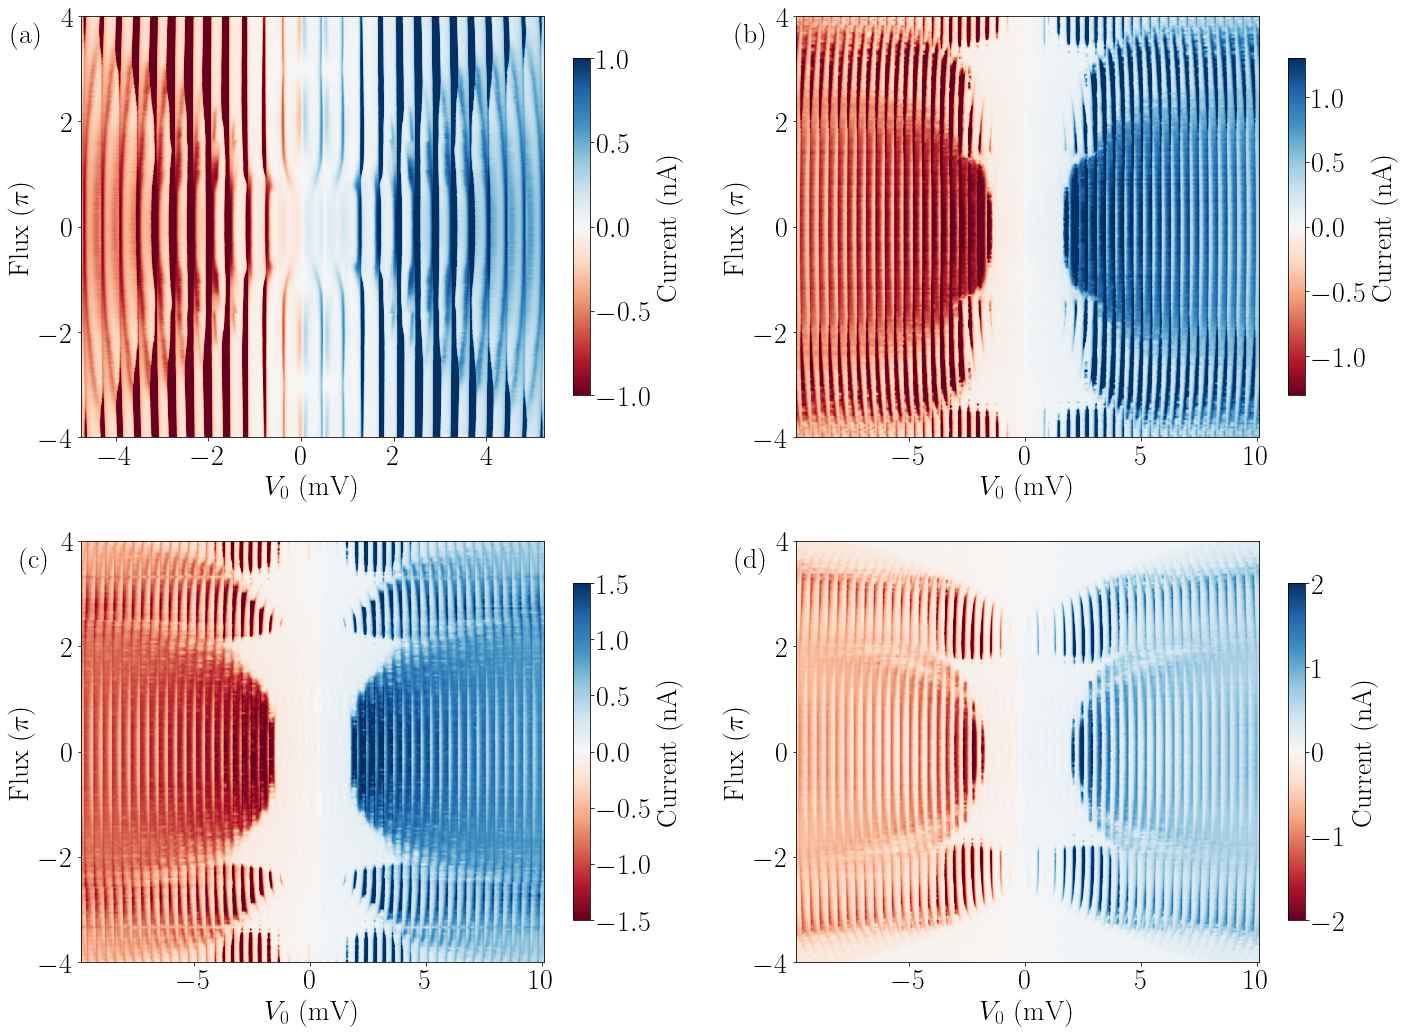

In [21]:
# plotting

fig, ax = plt.subplots(2,2, figsize=(20,15))
voltage_scaling = 1e3
voltage_offset_00 = 0.25e-3
voltage_offset_11 = 0.1e-3
current_scaling = 1e9

ivf_00 = ax[0,0].imshow(current_scaling*flux_steps[0], aspect='auto', 
               extent=[voltage_scaling*(np.min(flux_voltage[0]) + voltage_offset_00), voltage_scaling*(np.max(flux_voltage[0]) + voltage_offset_00), -4, 4], 
               cmap='RdBu', vmin = -1, vmax = 1)
ax[0,0].set_xlabel('$V_0$ (mV)')
ax[0,0].set_ylabel('Flux ($\pi$)')
cbar_00 = fig.colorbar(ivf_00, ax=ax[0,0], label='Current (nA)', shrink=0.8)
ax[0,0].text(-6.25, 3.5, '(a)')

ivf_01 = ax[0,1].imshow(current_scaling*flux_steps[1], aspect='auto', 
               extent=[voltage_scaling*(np.min(flux_voltage[1]) + voltage_offset_11), voltage_scaling*(np.max(flux_voltage[1]) + voltage_offset_11), -4, 4], 
               cmap='RdBu', vmin = -1.3, vmax = 1.3)
ax[0,1].set_xlabel('$V_0$ (mV)')
ax[0,1].set_ylabel('Flux ($\pi$)')
cbar_01 = fig.colorbar(ivf_01, ax=ax[0,1], label='Current (nA)', shrink=0.8)
ax[0,1].text(-12.5, 3.5, '(b)')

ivf_10 = ax[1,0].imshow(current_scaling*flux_steps[2], aspect='auto', 
               extent=[voltage_scaling*(np.min(flux_voltage[2]) + voltage_offset_11), voltage_scaling*(np.max(flux_voltage[2]) + voltage_offset_11), -4, 4], 
               cmap='RdBu', vmin = -1.5, vmax = 1.5)
ax[1,0].set_xlabel('$V_0$ (mV)')
ax[1,0].set_ylabel('Flux ($\pi$)')
cbar_10 = fig.colorbar(ivf_10, ax=ax[1,0], label='Current (nA)', shrink=0.8)
ax[1,0].text(-12.5, 3.5, '(c)')

ivf_11 = ax[1,1].imshow(current_scaling*flux_steps[3], aspect='auto', 
               extent=[voltage_scaling*(np.min(flux_voltage[3]) + voltage_offset_11), voltage_scaling*(np.max(flux_voltage[3]) + voltage_offset_11), -4, 4], 
               cmap='RdBu', vmin = -2, vmax = 2)
ax[1,1].set_xlabel('$V_0$ (mV)')
ax[1,1].set_ylabel('Flux ($\pi$)')
cbar_11 = fig.colorbar(ivf_11, ax=ax[1,1], label='Current (nA)', shrink=0.8)
ax[1,1].text(-12.5, 3.5, '(d)')

fig.tight_layout()

#plt.savefig('ivs_flux_all.pdf', bbox_inches='tight')

<h4>Steps at different frequencies</h4>

In [22]:
# loading
RUN_ID = 25
dataset = qc.load_by_id(run_id=RUN_ID)
iv3_stup = dataset.to_pandas_dataframe_dict()
RUN_ID = 26
dataset = qc.load_by_id(run_id=RUN_ID)
iv3_stdw = dataset.to_pandas_dataframe_dict()

RUN_ID = 27
dataset = qc.load_by_id(run_id=RUN_ID)
iv4_stup = dataset.to_pandas_dataframe_dict()
RUN_ID = 28
dataset = qc.load_by_id(run_id=RUN_ID)
iv4_stdw = dataset.to_pandas_dataframe_dict()

RUN_ID = 29
dataset = qc.load_by_id(run_id=RUN_ID)
iv6_stup = dataset.to_pandas_dataframe_dict()
RUN_ID = 30
dataset = qc.load_by_id(run_id=RUN_ID)
iv6_stdw = dataset.to_pandas_dataframe_dict()

<h4>Unaveraged steps</h4>

In [23]:
# loading
RUN_ID = 31
dataset = qc.load_by_id(run_id=RUN_ID)
iv5_stup = dataset.to_pandas_dataframe_dict()
RUN_ID = 32
dataset = qc.load_by_id(run_id=RUN_ID)
iv6b_stup = dataset.to_pandas_dataframe_dict()

In [24]:
# run 28,31 3ghz up down 
# run 29,32 4ghz up down
# run 30,33 6ghz up down
# run 35, 37 5,6ghz no avg

# 3 GHz plus and minus
iv3_0 = iv3_stup['adwin_up_ramp']
iv3_1 = iv3_0.reset_index()
v_3p = iv3_1['adwin_input_2_voltage_up'].to_numpy()
i_3p = iv3_1['adwin_up_ramp'].to_numpy()

iv3_0 = iv3_stdw['adwin_down_ramp']
iv3_1 = iv3_0.reset_index()
v_3m = iv3_1['adwin_input_2_voltage_down'].to_numpy()
i_3m = iv3_1['adwin_down_ramp'].to_numpy()

# 4 GHz plus and minus
iv4_0 = iv4_stup['adwin_up_ramp']
iv4_1 = iv4_0.reset_index()
v_4p = iv4_1['adwin_input_2_voltage_up'].to_numpy()
i_4p = iv4_1['adwin_up_ramp'].to_numpy()

iv4_0 = iv4_stdw['adwin_down_ramp']
iv4_1 = iv4_0.reset_index()
v_4m = iv4_1['adwin_input_2_voltage_down'].to_numpy()
i_4m = iv4_1['adwin_down_ramp'].to_numpy()

# 6 GHz plus and minus
iv6_0 = iv6_stup['adwin_up_ramp']
iv6_1 = iv6_0.reset_index()
v_6p = iv6_1['adwin_input_2_voltage_up'].to_numpy()
i_6p = iv6_1['adwin_up_ramp'].to_numpy()

iv6_0 = iv6_stdw['adwin_down_ramp']
iv6_1 = iv6_0.reset_index()
v_6m = iv6_1['adwin_input_2_voltage_down'].to_numpy()
i_6m = iv6_1['adwin_down_ramp'].to_numpy()

# unaveraged 5GHz and 6GHz IVs
iv5_0 = iv5_stup['adwin_up_ramp']
iv5_1 = iv5_0.reset_index()
v_5p = iv5_1['adwin_input_2_voltage_up'].to_numpy()
i_5p = iv5_1['adwin_up_ramp'].to_numpy()

iv6b_0 = iv6b_stup['adwin_up_ramp']
iv6b_1 = iv6b_0.reset_index()
v_6bp = iv6b_1['adwin_input_2_voltage_up'].to_numpy()
i_6bp = iv6b_1['adwin_up_ramp'].to_numpy()

<h4>Metrology</h4>

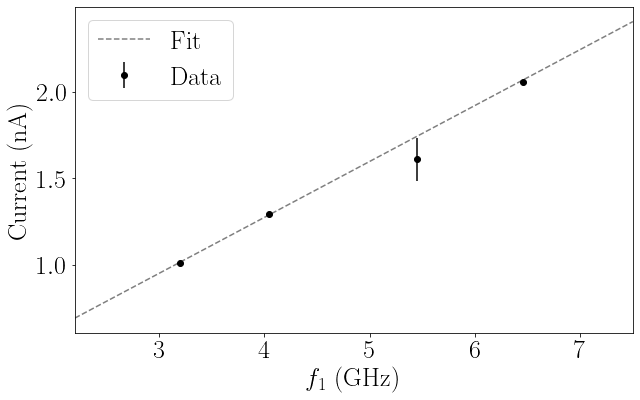

In [25]:
# average on the flat part of the plateaux
scale = 1e2
e = 1.602e-19
current_scale = 1e9
frequency_scale = 1e-9

m3 = np.mean(i_3p[660:688]/scale)
s3 = np.std(i_3p[660:688]/scale)

m4 = np.mean(i_4p[300:500]/scale)
s4 = np.std(i_4p[300:500]/scale)

m5 = np.mean(i_5p[400:630]/scale)
s5 = np.std(i_5p[400:630]/scale)

m6 = np.mean(i_6p[570:670]/scale)
s6 = np.std(i_6p[570:670]/scale)

fa = np.array([ 3.20e9, 4.04e9, 5.45e9, 6.46e9 ])
fa_plot = np.linspace(2.2e9,7.5e9, 1001)
ma = np.array([ m3, m4, m5, m6 ])
sa = np.array([ s3, s4, s5, s6 ])
q_fit = np.polyfit(fa, ma, 1, w=np.reciprocal(sa))
q_line = np.poly1d( q_fit)


plt.figure(figsize=(10,6))
plt.rc('font', family = 'serif', size=26)

plt.errorbar(frequency_scale*fa, current_scale*ma, current_scale*sa, marker='o', linestyle='None', color='black', label='Data')
plt.plot(frequency_scale*fa_plot, current_scale*q_line(fa_plot), linestyle='dashed', color='black', alpha=0.5, label='Fit')
plt.xlim([2.2, 7.5])
plt.xlabel('$f_1$ (GHz)')
plt.ylabel('Current (nA)')
plt.legend()

#plt.savefig("if.pdf", bbox_inches='tight')

In [26]:
# charge of the electron
fit, cov = np.polyfit(fa, ma, 1, w=np.reciprocal(sa), cov=True)

CP_charge = fit[0] 
CP_charge_error = np.sqrt(cov[0,0]) 

print('Estimated electron charge = ', CP_charge, '+-', CP_charge_error, 'C')
print('The percentage error is ', CP_charge_error/CP_charge, '%')

Estimated electron charge =  3.229935145234464e-19 +- 7.346831582947727e-21 C
The percentage error is  0.022746065331334737 %


<h4>Plateaux accuracy</h4>

Average current mean =  0.00026046113487477495
Average current deviation =  0.0011988532035857203


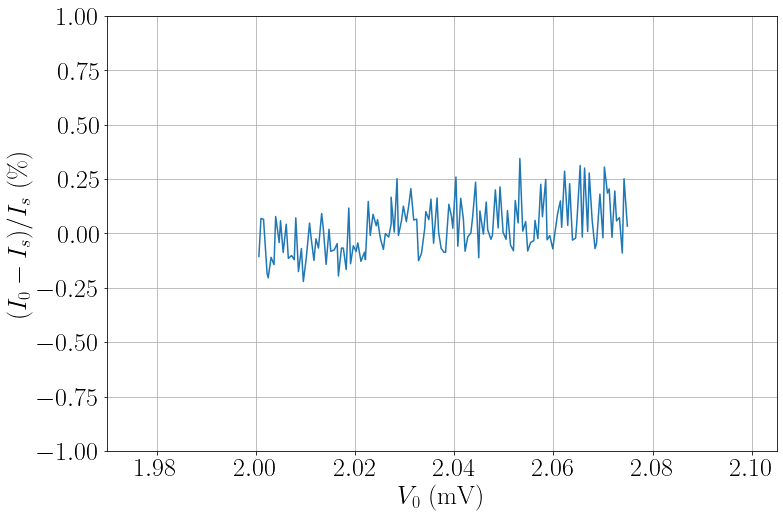

In [28]:
plt.figure(figsize=(12,8))
current_scale = 1e7

c3 = '#052747' #'#DEA98C'
c4 = '#2D7BC4' #'#AEDFA3'
c6 = '#579CDE' #'#BAB8DE'
f3 = 3.20e9
f4 = 4.04e9
f6 = 6.46e9
e = 1.602e-19

plt.plot(v_4p, current_scale*i_4p, c=c4, linewidth=2)
plt.hlines(2*e*f4*1e9, np.min(v_4p), np.max(v_4p), linestyles='dashed', colors='black', alpha=0.25)

start = 320
stop = 470
plt.plot(v_4p[start:stop], 100*(current_scale*i_4p[start:stop] - 2*e*f4*1e9)/2*e*f4*1e9)

plt.xlim([1.97,2.105])
plt.ylim([-1,1])
plt.xlabel('$V_0$ (mV)')
plt.ylabel('$(I_0-I_s)/I_s$ (\%)')

plt.grid()
print('Average current mean = ', np.mean(current_scale*i_4p[start:stop] - 2*e*f4*1e9)/2*e*f4*1e9)
print('Average current deviation = ', np.std(current_scale*i_4p[start:stop] - 2*e*f4*1e9)/2*e*f4*1e9)
#plt.savefig('residuals_step.pdf', bbox_inches='tight')

<h3>Paper plot</h3>

In [29]:
# run 28,31 3ghz up down 
# run 29,32 4ghz up down
# run 30,33 6ghz up down
# run 35, 37 5,6ghz no avg

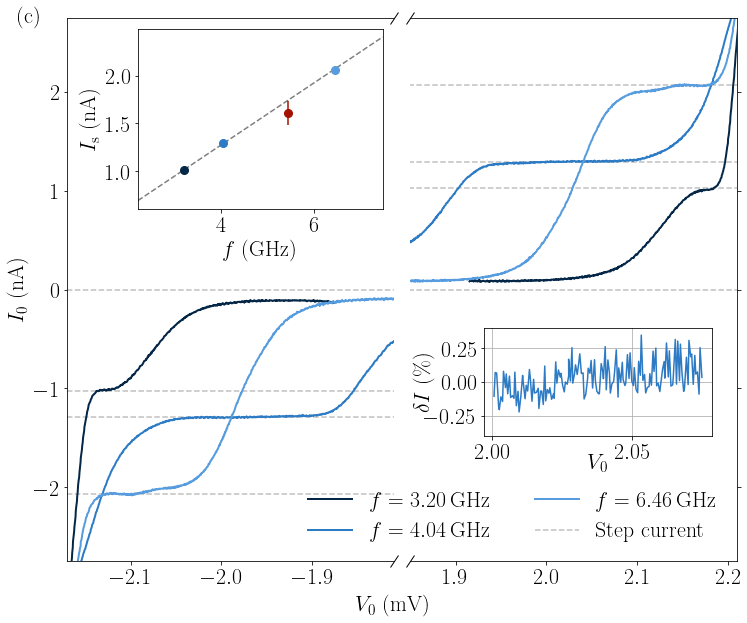

In [30]:
plt.rc('font', family = 'serif', size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,10), sharey=True)
fig.subplots_adjust(wspace=0.05)

current_scale = 1e7 # acquired with the wrong scale (software), this normalisation corresponds to nA
negative_voltage_offset = 0.2 # probably due to the measurement conditions (ramp frequency and amplifier gain) we see a small voltage offset

c3 = '#052747' #'#DEA98C'
c4 = '#2D7BC4' #'#AEDFA3'
c6 = '#579CDE' #'#BAB8DE'
f3 = 3.20e9
f4 = 4.04e9
f6 = 6.46e9
e = 1.602e-19

ax1.plot(v_3m[230::]-negative_voltage_offset, current_scale*i_3m[230::], c=c3, label='$f=3.20\,\mathrm{GHz}$', linewidth=2)
ax1.plot(v_4m-negative_voltage_offset, current_scale*i_4m, c=c4, label='$f=4.04\,\mathrm{GHz}$', linewidth=2)
ax1.plot(v_6m-negative_voltage_offset, current_scale*i_6m, c=c6, label='$f=6.46\,\mathrm{GHz}$', linewidth=2)
ax1.hlines(-2*e*f3*1e9, -5, 0, linestyles='dashed', colors='black', alpha=0.25)
ax1.hlines(-2*e*f4*1e9, -5, 0, linestyles='dashed', colors='black', alpha=0.25)
ax1.hlines(-2*e*f6*1e9, -5, -1.75, linestyles='dashed', colors='black', alpha=0.25)
ax1.hlines(0, -5, 0, linestyles='dashed', colors='black', alpha=0.25)


ax2.plot(v_3p[150::], current_scale*i_3p[150::], c=c3, label='$f=3.20\,\mathrm{GHz}$', linewidth=2)
ax2.plot(v_4p, current_scale*i_4p, c=c4, label='$f=4.04\,\mathrm{GHz}$', linewidth=2)
ax2.plot(v_6p, current_scale*i_6p, c=c6, label='$f=6.46\,\mathrm{GHz}$', linewidth=2)
ax2.hlines(2*e*f3*1e9, 5, 0, linestyles='dashed', colors='black', alpha=0.25, label='Step current')
ax2.hlines(2*e*f4*1e9, 5, 0, linestyles='dashed', colors='black', alpha=0.25)
ax2.hlines(2*e*f6*1e9, 5, 0, linestyles='dashed', colors='black', alpha=0.25)
ax2.hlines(0, 5, 0, linestyles='dashed', colors='black', alpha=0.25)

ax1.spines['right'].set_visible(False)
ax1.yaxis.tick_left()
ax2.spines['left'].set_visible(False)
ax2.yaxis.tick_right()

ax1.set_ylim([-2.75,2.75])
ax1.set_xlim([-2.17,-1.81])
ax2.set_xlim([1.85,2.21])

# horizontal lines
d = 1.5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([1, 1], [1, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 0], [0, 1], transform=ax2.transAxes, **kwargs)

ax1.text(-2.225,2.7, '(c)')
ax1.set_xlabel('$V_0$ (mV)')
ax1.xaxis.set_label_coords(1.0, -0.06)
ax1.set_ylabel('$I_0$ (nA)')
ax2.legend(loc='lower right', ncol=2, frameon=False)


# insets
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# subfigure 1
axins1 = inset_axes(ax1, width=3.4, height=2.5)
colors = np.array([c3,c4,'#A41100',c6])

for i in range( len(ma) ):
    axins1.errorbar(frequency_scale*fa[i], 1e9*ma[i], 1e9*sa[i], marker='o', markersize=8, linestyle='None', color=colors[i], label='Data')
   
axins1.plot(frequency_scale*fa_plot, 1e9*q_line(fa_plot), linestyle='dashed', color='black', alpha=0.5, label='Fit')
axins1.set_xlim([2.2, 7.5])
axins1.set_xlabel('$f$ (GHz)')
axins1.set_ylabel('$I_\mathrm{s}$ (nA)')
#axins1.legend()

# subfigure 2
axins2 = ax2.inset_axes((0.225, 0.23, 0.7, 0.2))

start = 320#250
stop = 470#550
axins2.plot(v_4p[start:stop], 100*(current_scale*i_4p[start:stop] - 2*e*f4*1e9)/2*e*f4*1e9, color=c4)

#axins2.set_xlim([1.97,2.1])
axins2.set_ylim([-0.4,0.4])
axins2.set_xlabel('$V_0$', labelpad=-10)
axins2.set_ylabel('$\delta I$ (\%)', labelpad=-12)#('$(I_0-I_s)/I_s$ (\%)')
axins2.grid()
#axins2.legend()

#plt.savefig("steps.pdf", bbox_inches='tight')